In [747]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [749]:
# To Do

# 1. track the mixed strategies
# 2. change evaluation of correlated strategy
# 3. change updating of correlated strategy

# to evaluate correlated strategies, need product distribution on message set

In [751]:
"""

LEARN BETTER THE PROBA MESSAGE DISTRIBUTION
1. define Q-learning properly on message distrib.
2. now it is like \alpha = 0


-- adjust the frequency matrix labels

"""

'\n\nLEARN BETTER THE PROBA MESSAGE DISTRIBUTION\n1. define Q-learning properly on message distrib.\n2. now it is like \x07lpha = 0\n\n\n-- adjust the frequency matrix labels\n\n'

In [753]:
# NOTE: THIS FUNCTION FIND THE SOCIAL WELFARE OF MIXED STRATEGIES (TO APPLY CONDITIONAL ON MESSAGES), NOT CORRELATED STRATEGY
# USEFUL BECAUSE WE WILL FIND THE BEST CONDITIONAL MIXED STRATEGY
# BUT WE MAY WANT TO FIND THE BEST CORRELATED STRATEGY
# THEN WE SHOULD THINK ABOUT THE WAY OF UPDATING THE MESSAGE DISTRIBUTION

def social_welfare_function(payoffs, mixed_strategies):
    """
    Compute the social welfare of a given strategy profile.

    Parameters:
        payoffs (list): A 2x2 matrix of payoffs for all players.
                        payoffs[0] contains the payoffs for player 1, and
                        payoffs[1] contains the payoffs for player 2.
        mixed_strategies (list): List of mixed strategies for both players.

    Returns:
        float: Social welfare value.
    """
    # Extract mixed strategies for both players
    x1 = mixed_strategies[0]  # Player 1's mixed strategy
    x2 = mixed_strategies[1]  # Player 2's mixed strategy

    # Calculate the social welfare
    social_welfare = 0
    num_actions = len(x1)
    # num_actions = 2

    for a1 in range(num_actions):
        for a2 in range(num_actions):
            # Probability of (a1, a2) being played
            prob = x1[a1] * x2[a2]
            # Payoffs for both players at (a1, a2)
            u1 = payoffs[0][a1][a2]
            u2 = payoffs[1][a2][a1]
            # Add the total payoff to the social welfare
            social_welfare += prob * (u1 + u2)

    return social_welfare

In [755]:
# you should output the correlated strategy, the weighted mixed strategy does not make mus sense

def q_learning_with_social_welfare(payoffs, T, alpha, beta0, k, messages, initial_message_probabilities, welfare_function):
    """
    Q-learning algorithm for a finite 2x2 game with social welfare and adaptive message probabilities.

    Outputs:
    - last iterate correlated strategy
    - last iterate social welfare
    - last iterate message probability
    - frequency of play
    - action history
    - average mixed strategies
    - conditional last iterate mixed strategies
    - social welfare over time
    """
    num_players = 2
    num_actions = 2
    num_messages = len(messages)

    if len(initial_message_probabilities) != num_messages:
        raise ValueError(f"Initial message probabilities must match the number of messages. "
                         f"Expected length {num_messages}, got {len(initial_message_probabilities)}.")

    # Initialize Q-values for all players and messages
    Q = [{message: np.zeros(num_actions) for message in messages} for _ in range(num_players)]
    W = np.ones(num_messages)
    message_probabilities = np.array(initial_message_probabilities)

    # Track data
    strategies = {message: [np.array([0.5, 0.5]) for _ in range(num_players)] for message in messages}
    action_counts = {message: [np.zeros(num_actions) for _ in range(num_players)] for message in messages}
    action_history = [[] for _ in range(num_players)]
    conditional_strategies_history = {message: [] for message in messages}
    correlated_strategy_history = []
    social_welfare = 0
    social_welfare_history = []
    message_probabilities_history = []

    action_profiles = [(0, 0), (0, 1), (1, 0), (1, 1)]
    correlated_strategy = {profile: 0 for profile in action_profiles}

    for t in range(1, T + 1):
        beta = beta0 + k*t
        # Sample a message based on probabilities
        message = np.random.choice(messages, p=message_probabilities)
        mixed_strategies = []

        # Compute mixed strategies
        for i in range(num_players):
            mixed_strategy = np.exp(beta * Q[i][message]) / np.sum(np.exp(beta * Q[i][message]))
            mixed_strategies.append(mixed_strategy)

        strategies[message] = mixed_strategies

        # Save current conditional mixed strategies
        for i in range(num_players):
            conditional_strategies_history[message].append(mixed_strategies[i].copy())

        # Sample actions
        actions = [np.random.choice(num_actions, p=mixed_strategies[i]) for i in range(num_players)]
        for i in range(num_players):
            action_history[i].append(actions[i])
            action_counts[message][i][actions[i]] += 1

        # Compute payoffs
        rewards = [payoffs[i][actions[i]][actions[1 - i]] for i in range(num_players)]
        rewards_counterf = [payoffs[i][1-actions[i]][actions[1-i]] for i in range(num_players)]

        # Update Q-values
        for i in range(num_players):
            Q[i][message][actions[i]] = (1 - alpha) * Q[i][message][actions[i]] + rewards[i]
            Q[i][message][1-actions[i]] = (1-alpha) * Q[i][message][1-actions[i]] + rewards_counterf[i]

        # Compute social welfare
        social_welfares = {}
        for m in messages:
            latest_strategies = strategies[m]
            social_welfares[m] = welfare_function(payoffs, latest_strategies)
      
        # Update message probabilities
        k1 = 0.001
        a1 = 1
        b1 = beta0 + k1*t
        social_welfare_values = np.array(list(social_welfares.values()))
        if np.sum(social_welfare_values) == 0:
            social_welfare_values += 1e-6

        for i in range(num_messages):
            W[i] = (1-a1) * W[i] + social_welfare_values[i]
        
        exp_values = np.exp(b1 * W)
        #exp_values = np.exp(b1 * social_welfare_values)
        
        message_probabilities = exp_values / np.sum(exp_values)
        message_probabilities_history.append(message_probabilities)

        # message_probabilities = social_welfare_values / np.sum(social_welfare_values)
        # message_probabilities_history.append(message_probabilities)

        # Update correlated strategy
        correlated_strategy = {profile: 0 for profile in action_profiles}
        for m, prob_m in zip(messages, message_probabilities):
            for a1 in range(num_actions):
                for a2 in range(num_actions):
                    profile = (a1, a2)
                    correlated_strategy[profile] += prob_m * strategies[m][0][a1] * strategies[m][1][a2]

        total_probability = sum(correlated_strategy.values())
        for profile in correlated_strategy:
            correlated_strategy[profile] /= total_probability

        # Save correlated strategy and compute social welfare of correlated strategy
        correlated_strategy_snapshot = correlated_strategy.copy()
        correlated_strategy_history.append(correlated_strategy_snapshot)
        for m, prob_m in zip(messages, message_probabilities):
            social_welfare += prob_m * social_welfares[m]
        social_welfare_history.append(social_welfare)
        social_welfare = 0

    # Compute averages
    avg_mixed_strategies = {
        message: [
            np.mean([strategies[message][i]], axis=0)
            for i in range(num_players)
        ]
        for message in messages
    }

    last_iterate_strategies = {
        message: [strategies[message][i] for i in range(num_players)]
        for message in messages
    }

    frequencies = {
        message: [counts / T for counts in action_counts[message]]
        for message in messages
    }

    return {
        "last_iterate": last_iterate_strategies,
        "average_mixed_strategy": avg_mixed_strategies,
        "adaptive_message_probabilities": message_probabilities,
        "correlated_strategy": correlated_strategy,
        "correlated_strategy_history": correlated_strategy_history,
        "conditional_strategies_history": conditional_strategies_history,
        "message_probabilities_history": message_probabilities_history,
        "social_welfare_history": social_welfare_history,
        "frequency_of_play": frequencies,
        "action_history": action_history
    }

In [757]:
# Example 2x2 game payoffs (HD game):
"""
payoffs = [
    [[5, 2], [7, 1]],  # Payoffs for Player 0
    [[5, 2], [7, 1]]   # Payoffs for Player 1
]

"""
"""
# Example 2x2 game payoffs (Coordination game):
payoffs = [
    [[0, 1], [2, 0]],  # Payoffs for Player 0
    [[0, 2], [1, 0]]   # Payoffs for Player 1
]
"""
# Example 2x2 game payoffs (Prisoner dilemma):
payoffs = [
    [[2, 0], [5, 0]],  # Payoffs for Player 0
    [[2, 0], [5, 0]]   # Payoffs for Player 1
]

# pick a game at random
"""
payoffs = [
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1
]
"""

'\npayoffs = [\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1\n]\n'

In [759]:
payoffs

[[[2, 0], [5, 0]], [[2, 0], [5, 0]]]

In [761]:
# Q-learning parameters
T = 2000
alpha = 0.3
beta = 0.01
k = 0.001
messages = ['m1', 'm2']  # Example messages
initial_message_probabilities = [0.5, 0.5]  # Initial message probabilities

# messages = ['m1', 'm2', 'm3','m4']  # Example messages
# initial_message_probabilities = [0.25, 0.25, 0.25, 0.25]  # Initial message probabilities

In [763]:
# Run the Q-learning algorithm
results = q_learning_with_social_welfare(
    payoffs,
    T,
    alpha,
    beta,
    k, 
    messages,
    initial_message_probabilities,
    social_welfare_function
)

# Display results
print("Last iterate mixed strategies (by message):", results["last_iterate"])
print("Average mixed strategies (by message):", results["average_mixed_strategy"])
print("Adaptive message probabilities:", results["adaptive_message_probabilities"])
print("Last iterated correlated strategy:", results["correlated_strategy"])
# print("Social welfare:", results["social_welfare_weighted_last"])
print("Frequency of play:", results["frequency_of_play"])

Last iterate mixed strategies (by message): {'m1': [array([0.02197215, 0.97802785]), array([0.00240691, 0.99759309])], 'm2': [array([0.5, 0.5]), array([3.23904536e-08, 9.99999968e-01])]}
Average mixed strategies (by message): {'m1': [array([0.02197215, 0.97802785]), array([0.00240691, 0.99759309])], 'm2': [array([0.5, 0.5]), array([3.23904536e-08, 9.99999968e-01])]}
Adaptive message probabilities: [0.00832091 0.99167909]
Last iterated correlated strategy: {(0, 0): 4.5611232346273366e-07, (0, 1): 0.4960219178659748, (1, 0): 1.9603716811033766e-05, (1, 1): 0.5039580223048907}
Frequency of play: {'m1': [array([0.1135, 0.4375]), array([0.1695, 0.3815])], 'm2': [array([0.083, 0.366]), array([0.161, 0.288])]}


In [764]:
"""
# Map actions to labels for plotting
# Plot the sequence of play for each player
plt.figure(figsize=(10, 6))
plt.plot(
    results["action_history"][0],
    label="Player 0's actions",
    alpha=0.7,
    marker='o',
    linestyle='-'
)
plt.plot(
    results["action_history"][1],
    label="Player 1's actions",
    alpha=0.7,
    marker='x',
    linestyle='--'
)
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.title("Sequence of Play Over Time")
plt.yticks([0, 1], action_labels)  # Use "Cooperate" and "Defect" instead of 0 and 1
plt.legend()
plt.grid()
plt.show()
"""

'\n# Map actions to labels for plotting\n# Plot the sequence of play for each player\nplt.figure(figsize=(10, 6))\nplt.plot(\n    results["action_history"][0],\n    label="Player 0\'s actions",\n    alpha=0.7,\n    marker=\'o\',\n    linestyle=\'-\'\n)\nplt.plot(\n    results["action_history"][1],\n    label="Player 1\'s actions",\n    alpha=0.7,\n    marker=\'x\',\n    linestyle=\'--\'\n)\nplt.xlabel("Time Step")\nplt.ylabel("Action")\nplt.title("Sequence of Play Over Time")\nplt.yticks([0, 1], action_labels)  # Use "Cooperate" and "Defect" instead of 0 and 1\nplt.legend()\nplt.grid()\nplt.show()\n'

In [767]:
# print("History of correlated strategies:", results["correlated_strategy_history"])

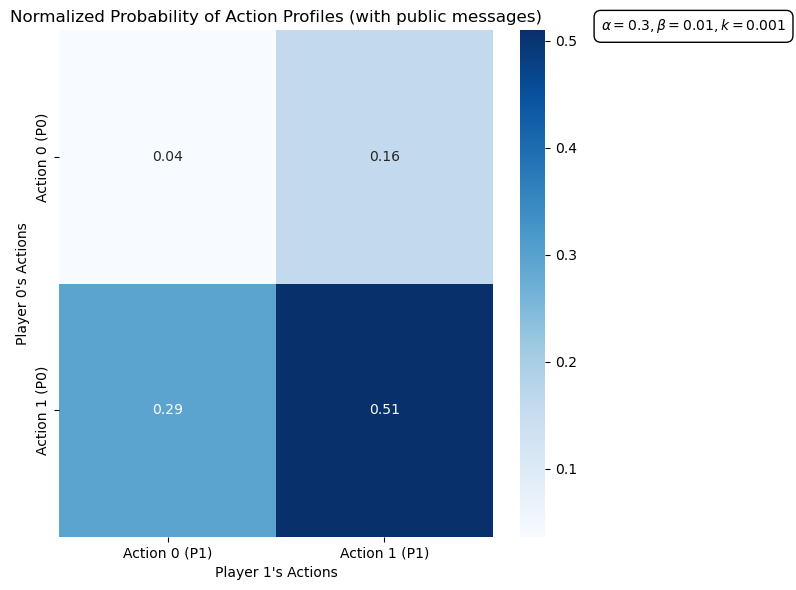

In [769]:
# Extract action history
action_history_0 = results["action_history"][0]  # Player 0's actions
action_history_1 = results["action_history"][1]  # Player 1's actions

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = 2  # Assuming binary actions (0 and 1)
frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0, action_history_1):
    frequency_matrix[a0, a1] += 1

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob = frequency_matrix / np.sum(frequency_matrix)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 0 (P0)", "Action 1 (P0)"]
)
plt.title("Normalized Probability of Action Profiles (with public messages)")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_PrisonerDilemma_public_msg.png")

plt.show()

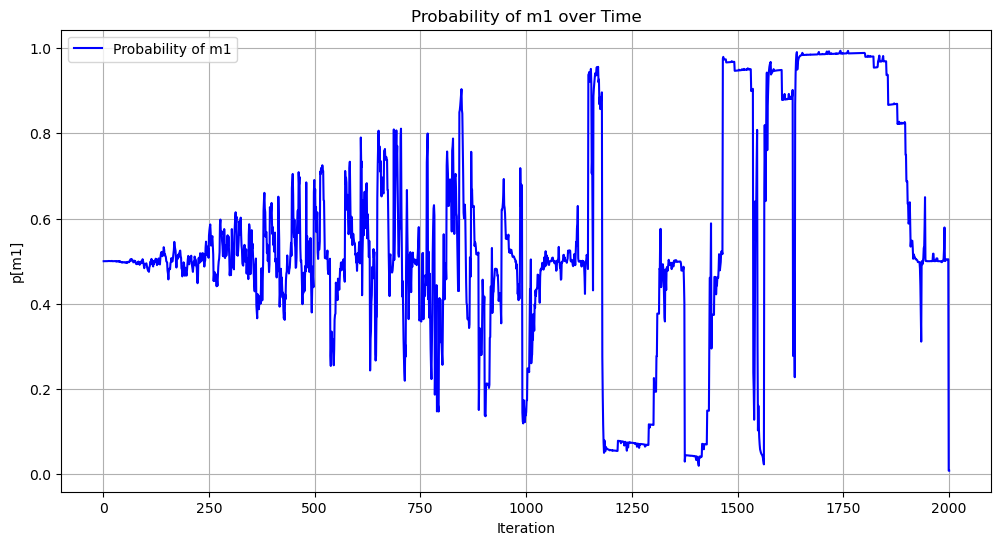

In [770]:
message_probabilities_history = results["message_probabilities_history"]

# Extract the probability history for message 'm1'
proba_m1_history = [probabilities[0] for probabilities in message_probabilities_history]

# Plot the probability of m1 over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(proba_m1_history) + 1), proba_m1_history, label="Probability of m1", color="blue")
plt.title("Probability of m1 over Time")
plt.xlabel("Iteration")
plt.ylabel("p[m1]")
plt.grid()
plt.legend()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/messages_PrisonerDilemma_public_msg.png")
plt.show()

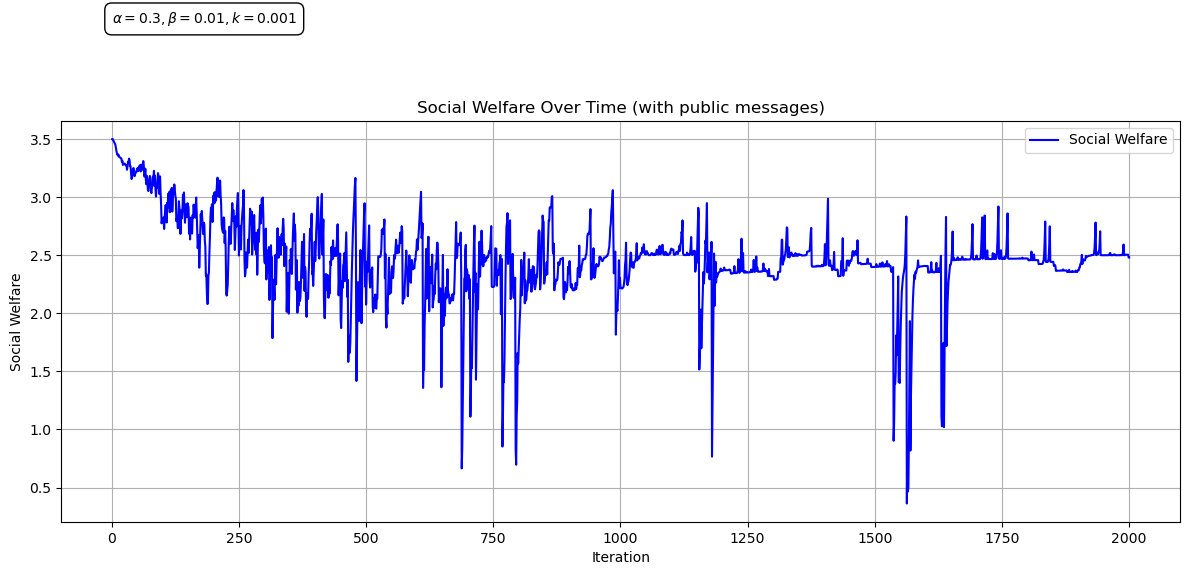

In [773]:
# social welfare over time

social_welfare_history = results["social_welfare_history"]

# Plot social welfare over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), social_welfare_history, label="Social Welfare", color="blue")
plt.title("Social Welfare Over Time (with public messages)")
plt.xlabel("Iteration")
plt.ylabel("Social Welfare")
plt.grid()
plt.legend()

plt.text(
    0, 4.5,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/welfare_PrisonerDilemma_public_msg.png")

plt.show()

In [774]:
# print("History of conditional mixed strategies:", results["conditional_strategies_history"])

In [777]:
# avergae social welfare

average_SW = np.sum(social_welfare_history)/T
average_SW

2.465322063909989

In [779]:
# standard algorithm without message selection
# Q-learning parameters
messages_stand = ['m1']  # Example messages
initial_message_probabilities_stand = [1]  # Initial message probabilities

results_stand = q_learning_with_social_welfare(
    payoffs,
    T,
    alpha,
    beta,
    k,
    messages_stand,
    initial_message_probabilities_stand,
    social_welfare_function
)

# Display results
print("Last iterate mixed strategies (by message):", results_stand["last_iterate"])
print("Average mixed strategies (by message):", results_stand["average_mixed_strategy"])
print("Adaptive message probabilities:", results_stand["adaptive_message_probabilities"])
print("Last iterated correlated strategy:", results_stand["correlated_strategy"])
# print("Social welfare:", results["social_welfare_weighted_last"])
print("Frequency of play:", results_stand["frequency_of_play"])

Last iterate mixed strategies (by message): {'m1': [array([0.09620432, 0.90379568]), array([0.00239972, 0.99760028])]}
Average mixed strategies (by message): {'m1': [array([0.09620432, 0.90379568]), array([0.00239972, 0.99760028])]}
Adaptive message probabilities: [1.]
Last iterated correlated strategy: {(0, 0): 0.00023086356267618653, (0, 1): 0.09597345274116094, (1, 0): 0.002168857900413495, (1, 1): 0.9016268257957494}
Frequency of play: {'m1': [array([0.1955, 0.8045]), array([0.3315, 0.6685])]}


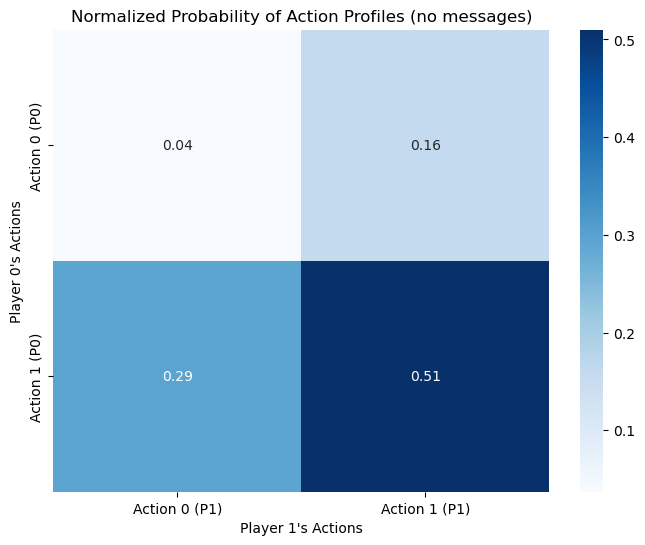

In [781]:
# Extract action history
action_history_0_stand = results_stand["action_history"][0]  # Player 0's actions
action_history_1_stand = results_stand["action_history"][1]  # Player 1's actions

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = 2  # Assuming binary actions (0 and 1)
frequency_matrix_stand = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0_stand, action_history_1_stand):
    frequency_matrix_stand[a0, a1] += 1

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob_stand = frequency_matrix_stand / np.sum(frequency_matrix_stand)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob_stand, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 0 (P0)", "Action 1 (P0)"]
)
plt.title("Normalized Probability of Action Profiles (no messages)")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_PrisonerDilemma_no_public_msg.png")
plt.show()

plt.show()

# Map actions to labels for plotting
action_labels = ["0", "1"]

# Plot the sequence of play for each player
plt.figure(figsize=(10, 6))
plt.plot(
    results["action_history"][0],
    label="Player 0's actions",
    alpha=0.7,
    marker='o',
    linestyle='-'
)
plt.plot(
    results["action_history"][1],
    label="Player 1's actions",
    alpha=0.7,
    marker='x',
    linestyle='--'
)
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.title("Sequence of Play Over Time")
plt.yticks([0, 1], action_labels)  # Use "Cooperate" and "Defect" instead of 0 and 1
plt.legend()
plt.grid()
plt.show()

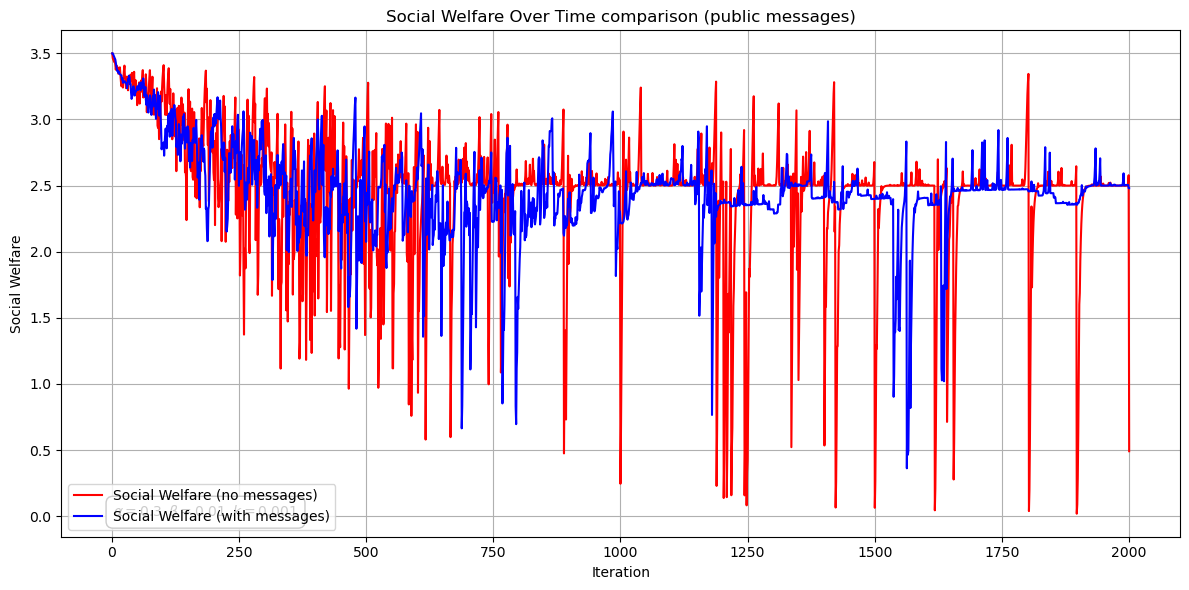

In [784]:
# social welfare over time

social_welfare_history_stand = results_stand["social_welfare_history"]

# Plot social welfare over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), social_welfare_history_stand, label="Social Welfare (no messages)", color="red")
plt.plot(range(1, T + 1), social_welfare_history, label="Social Welfare (with messages)", color="blue")
plt.title("Social Welfare Over Time comparison (public messages)")
plt.xlabel("Iteration")
plt.ylabel("Social Welfare")
plt.grid()
plt.legend()

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/welfare_comp_PrisonerDilemma_public_msg.png")
plt.show()

In [785]:
# avergae social welfare

average_SW_stand = np.sum(social_welfare_history_stand)/T
average_SW_stand

2.466857295199012

In [788]:
"""
comment: 
- you still reach the welfare maximizing profile, but faster

drawbacks:
- this algorithm is not really illuminating, as it is as if it selects the best RL dynamics choosen over time
- things may be different when considering general games and private messages
"""

'\ncomment: \n- you still reach the welfare maximizing profile, but faster\n\ndrawbacks:\n- this algorithm is not really illuminating, as it is as if it selects the best RL dynamics choosen over time\n- things may be different when considering general games and private messages\n'

In [790]:
average_SW - average_SW_stand

-0.001535231289023109